In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import torchvision

In [2]:
# Pretrained feature extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model = nn.Sequential(*list(self.model.children())[:-1])  # Remove the last layer

    def forward(self, x):
        with torch.no_grad():
            features = self.model(x)
        return features.view(features.size(0), -1)

In [3]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class TeacherStudentNetworks:
    def __init__(self, feature_dim, output_dim):
        self.teacher = SimpleNN(feature_dim, output_dim)
        self.student = SimpleNN(feature_dim, output_dim)

In [4]:
class FeatureAugmenter(nn.Module):
    def __init__(self, input_dim):
        super(FeatureAugmenter, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, input_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
class BinaryClassifier(nn.Module):
    def __init__(self, input_dim):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
class RealFakeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def load_image_paths_and_labels(root_dir):
    image_paths = []
    labels = []
    
    for model in os.listdir(root_dir):
        model_path = os.path.join(root_dir, model)
        if os.path.isdir(model_path):
            for label in ['0_real', '1_fake']:
                label_path = os.path.join(model_path, label)
                if os.path.isdir(label_path):
                    for img_name in os.listdir(label_path):
                        img_path = os.path.join(label_path, img_name)
                        image_paths.append(img_path)
                        labels.append(0 if '0_real' in label else 1)
                else:
                    for obj in os.listdir(model_path):
                        obj_path = os.path.join(model_path, obj)
                        label_path = os.path.join(obj_path, label)
                        if os.path.isdir(label_path):
                            for img_name in os.listdir(label_path):
                                img_path = os.path.join(label_path, img_name)
                                image_paths.append(img_path)
                                labels.append(0 if '0_real' in label else 1)
    
    return image_paths, labels

In [26]:
def train_teacher(teacher, feature_extractor, dataloader, device, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(teacher.parameters(), lr=0.001)
    feature_extractor.to(device)
    teacher.to(device)
    
    for epoch in range(num_epochs):
        teacher.train()
        running_loss = 0.0
        for images, labels in tqdm(dataloader, desc=f'Teacher training {epoch+1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)
            
            optimizer.zero_grad()
            outputs = teacher(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')
    
    print('Finished Training Teacher')

In [27]:
def train_student(teacher, student, feature_extractor, augmenter, dataloader, device, num_epochs=10, margin=1.0):
    optimizer = optim.Adam(student.parameters(), lr=0.001)
    teacher.to(device)
    student.to(device)
    augmenter.to(device)
    feature_extractor.to(device)
    
    for epoch in range(num_epochs):
        student.train()
        running_loss_real = 0.0
        running_loss_fake = 0.0
        
        for images, labels in tqdm(dataloader, desc=f'Student training {epoch+1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)
            
            # Real images
            real_indices = (labels == 0)
            real_features = features[real_indices]
            if len(real_features) > 0:
                teacher_real = teacher(real_features)
                student_real = student(real_features)
                loss_real = torch.mean((teacher_real - student_real) ** 2)
                
                optimizer.zero_grad()
                loss_real.backward()
                optimizer.step()
                
                running_loss_real += loss_real.item()
            
            # Fake images
            fake_indices = (labels == 1)
            fake_features = features[fake_indices]
            if len(fake_features) > 0:
                augmented_fake_features = augmenter(fake_features)
                teacher_fake = teacher(augmented_fake_features)
                student_fake = student(augmented_fake_features)
                discrepancy = torch.mean((teacher_fake / teacher_fake.norm(2, dim=1, keepdim=True) - student_fake / student_fake.norm(2, dim=1, keepdim=True)) ** 2)
                loss_fake = torch.clamp(margin - discrepancy, min=0.0)
                
                optimizer.zero_grad()
                loss_fake.backward()
                optimizer.step()
                
                running_loss_fake += loss_fake.item()
        
        print(f'Epoch {epoch+1}, Real Loss: {running_loss_real/len(dataloader)}, Fake Loss: {running_loss_fake/len(dataloader)}')
    
    print('Finished Training Student')

In [55]:
def train_binary_classifier(teacher, student, classifier, feature_extractor, dataloader, device, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(classifier.parameters(), lr=0.001)
    teacher.to(device)
    student.to(device)
    classifier.to(device)
    feature_extractor.to(device)
    
    for epoch in range(num_epochs):
        classifier.train()
        running_loss = 0.0
        
        for images, labels in tqdm(dataloader, desc=f'Classifier training {epoch+1}/{num_epochs}', unit='batch'):
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)
            
            with torch.no_grad():
                teacher_outputs = teacher(features)
                student_outputs = student(features)
            # print(f"Teacher outputs shape: {teacher_outputs.shape}")
            # print(f"Student outputs shape: {student_outputs.shape}")
            discrepancies = (teacher_outputs - student_outputs) ** 2
            outputs = classifier(discrepancies)
            
            optimizer.zero_grad()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}')
    
    print('Finished Training Binary Classifier')

In [76]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load image paths and labels
image_paths, labels = load_image_paths_and_labels(r'C:\Users\Danila\VSU\vsu_common_rep\vsu_common_rep\2year\2term\project\image_classification\content\CNN_synth\train_set')

# Create a dataset instance
full_dataset = RealFakeDataset(image_paths, labels, transform=transform)

# Define the split ratio
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Split the dataset
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize networks
feature_extractor = FeatureExtractor()
feature_dim = 2048  # ResNet50 output feature dimension
teacher_student = TeacherStudentNetworks(feature_dim, 2)
augmenter = FeatureAugmenter(feature_dim)
binary_classifier = BinaryClassifier(2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the teacher network
train_teacher(teacher_student.teacher, feature_extractor, train_loader, device)
torch.save(teacher_student.teacher.state_dict(), 'models/teacher_10ep.pth')

# Train the student network
train_student(teacher_student.teacher, teacher_student.student, feature_extractor, augmenter, train_loader, device)
torch.save(teacher_student.student.state_dict(), 'models/student_10ep.pth')

# Train the binary classifier
train_binary_classifier(teacher_student.teacher, teacher_student.student, binary_classifier, feature_extractor, train_loader, device)
torch.save(binary_classifier.state_dict(), 'models/classifier_10ep.pth')


C:\Users\Danila\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Danila\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Teacher training 1/10: 100%|████████████████████████████████████████████████████| 2259/2259 [15:26<00:00,  2.44batch/s]


Epoch 1, Loss: 0.37265733520295463


Teacher training 2/10: 100%|████████████████████████████████████████████████████| 2259/2259 [16:03<00:00,  2.34batch/s]


Epoch 2, Loss: 0.282593409899802


Teacher training 3/10: 100%|████████████████████████████████████████████████████| 2259/2259 [16:01<00:00,  2.35batch/s]


Epoch 3, Loss: 0.24916053107548414


Teacher training 4/10: 100%|████████████████████████████████████████████████████| 2259/2259 [15:33<00:00,  2.42batch/s]


Epoch 4, Loss: 0.23291326954716757


Teacher training 5/10: 100%|████████████████████████████████████████████████████| 2259/2259 [14:55<00:00,  2.52batch/s]


Epoch 5, Loss: 0.21732931549736306


Teacher training 6/10: 100%|████████████████████████████████████████████████████| 2259/2259 [14:12<00:00,  2.65batch/s]


Epoch 6, Loss: 0.20923572475599367


Teacher training 7/10: 100%|████████████████████████████████████████████████████| 2259/2259 [13:44<00:00,  2.74batch/s]


Epoch 7, Loss: 0.19693267667577852


Teacher training 8/10: 100%|████████████████████████████████████████████████████| 2259/2259 [13:44<00:00,  2.74batch/s]


Epoch 8, Loss: 0.18881297831173333


Teacher training 9/10: 100%|████████████████████████████████████████████████████| 2259/2259 [13:46<00:00,  2.73batch/s]


Epoch 9, Loss: 0.18226603169741226


Teacher training 10/10: 100%|███████████████████████████████████████████████████| 2259/2259 [13:46<00:00,  2.73batch/s]


Epoch 10, Loss: 0.17855071858142185
Finished Training Teacher


Student training 1/10: 100%|████████████████████████████████████████████████████| 2259/2259 [13:58<00:00,  2.69batch/s]


Epoch 1, Real Loss: 1.0633452800178802, Fake Loss: 0.00014825815012519368


Student training 2/10: 100%|████████████████████████████████████████████████████| 2259/2259 [13:57<00:00,  2.70batch/s]


Epoch 2, Real Loss: 0.5693289433738308, Fake Loss: 0.0


Student training 3/10: 100%|████████████████████████████████████████████████████| 2259/2259 [13:58<00:00,  2.70batch/s]


Epoch 3, Real Loss: 0.4281926139259085, Fake Loss: 0.0


Student training 4/10: 100%|████████████████████████████████████████████████████| 2259/2259 [14:04<00:00,  2.68batch/s]


Epoch 4, Real Loss: 0.35908669127780496, Fake Loss: 0.0


Student training 5/10: 100%|████████████████████████████████████████████████████| 2259/2259 [13:57<00:00,  2.70batch/s]


Epoch 5, Real Loss: 0.3101700327683598, Fake Loss: 5.339905982420686e-05


Student training 6/10: 100%|████████████████████████████████████████████████████| 2259/2259 [13:55<00:00,  2.70batch/s]


Epoch 6, Real Loss: 0.2926591619776645, Fake Loss: 0.0


Student training 7/10: 100%|████████████████████████████████████████████████████| 2259/2259 [13:55<00:00,  2.71batch/s]


Epoch 7, Real Loss: 0.25773860123165154, Fake Loss: 6.314028992806984e-08


Student training 8/10: 100%|████████████████████████████████████████████████████| 2259/2259 [13:58<00:00,  2.69batch/s]


Epoch 8, Real Loss: 0.25347882691785634, Fake Loss: 0.0


Student training 9/10: 100%|████████████████████████████████████████████████████| 2259/2259 [14:00<00:00,  2.69batch/s]


Epoch 9, Real Loss: 0.23418261849574148, Fake Loss: 0.0


Student training 10/10: 100%|███████████████████████████████████████████████████| 2259/2259 [14:03<00:00,  2.68batch/s]


Epoch 10, Real Loss: 0.2251587930329609, Fake Loss: 0.0
Finished Training Student


Classifier training 1/10: 100%|█████████████████████████████████████████████████| 2259/2259 [13:44<00:00,  2.74batch/s]


Epoch 1, Loss: 0.3853370917943686


Classifier training 2/10: 100%|█████████████████████████████████████████████████| 2259/2259 [13:43<00:00,  2.74batch/s]


Epoch 2, Loss: 0.3789268062936885


Classifier training 3/10: 100%|█████████████████████████████████████████████████| 2259/2259 [13:44<00:00,  2.74batch/s]


Epoch 3, Loss: 0.3759599620985109


Classifier training 4/10: 100%|█████████████████████████████████████████████████| 2259/2259 [13:40<00:00,  2.75batch/s]


Epoch 4, Loss: 0.3778783722016705


Classifier training 5/10: 100%|█████████████████████████████████████████████████| 2259/2259 [13:41<00:00,  2.75batch/s]


Epoch 5, Loss: 0.375498255796404


Classifier training 6/10: 100%|█████████████████████████████████████████████████| 2259/2259 [13:42<00:00,  2.75batch/s]


Epoch 6, Loss: 0.37703683886606115


Classifier training 7/10: 100%|█████████████████████████████████████████████████| 2259/2259 [13:42<00:00,  2.75batch/s]


Epoch 7, Loss: 0.3746690488147915


Classifier training 8/10: 100%|█████████████████████████████████████████████████| 2259/2259 [13:43<00:00,  2.74batch/s]


Epoch 8, Loss: 0.3750195799839871


Classifier training 9/10: 100%|█████████████████████████████████████████████████| 2259/2259 [13:42<00:00,  2.75batch/s]


Epoch 9, Loss: 0.37445053246800697


Classifier training 10/10: 100%|████████████████████████████████████████████████| 2259/2259 [13:45<00:00,  2.74batch/s]

Epoch 10, Loss: 0.37476671759852165
Finished Training Binary Classifier


In [18]:
print(device)

cuda


In [ ]:
# model saving
torch.save(, 'CNN_simple_classifier_76acc_.04loss')

In [57]:
torch.save(teacher_student.teacher.state_dict(), 'models/teacher_1ep.pth')
torch.save(teacher_student.student.state_dict(), 'models/student_1ep.pth')
torch.save(binary_classifier.state_dict(), 'models/classifier_1ep.pth')

In [140]:
mytest_image_paths, mytest_labels = load_image_paths_and_labels(r"C:\Users\Danila\VSU\vsu_common_rep\vsu_common_rep\2year\2term\project\image_classification\content\CNN_synth\validation")
mytest_dataset = RealFakeDataset(test_image_paths, test_labels, transform=transform)
mytest_loader = DataLoader(mytest_dataset, batch_size=32, shuffle=False)

In [141]:
print(len(mytest_dataset))

1394


In [86]:
def test_binary_classifier(teacher, student, classifier, feature_extractor, dataloader, device):
    classifier.eval()  # Set the classifier to evaluation mode
    teacher.eval()
    student.eval()
    classifier.eval()
    
    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # Disable gradient calculation for testing
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Extract features
            features = feature_extractor(images)
            
            # Get outputs from teacher and student networks
            teacher_outputs = teacher(features)
            student_outputs = student(features)
            
            # Calculate discrepancy
            discrepancy = (teacher_outputs - student_outputs) ** 2
            
            # Get predictions from binary classifier
            outputs = classifier(discrepancy)
            _, preds = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f'Test Accuracy: {accuracy * 100:.2f}%')
    return accuracy

In [137]:
test_binary_classifier(teacher_student.teacher, teacher_student.student, binary_classifier, feature_extractor, mytest_loader, device)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Danila\\VSU\\vsu_common_rep\\vsu_common_rep\\2year\\2term\\project\\image_classification\\content\\CNN_synth\\validation\\test_model\\0_real\\.trashed-1717667950-IMG20240507125905_01.jpg'

100%|████████████████████████████████████████████████████████████████████████████████| 565/565 [03:26<00:00,  2.73it/s]


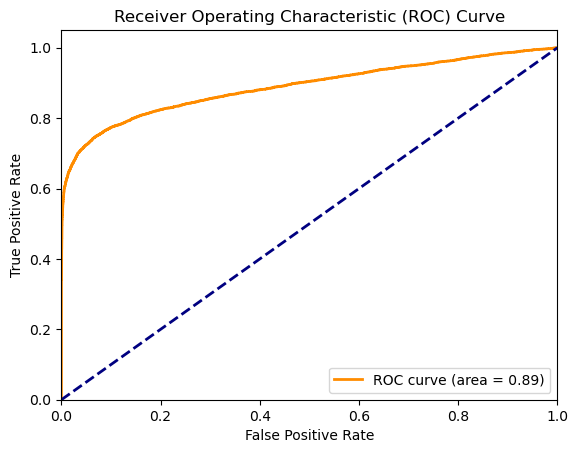

In [90]:
# AUC ROC calculation
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

teacher_student.teacher.eval()
teacher_student.student.eval()
binary_classifier.eval()

# Lists to store true labels and predicted probabilities
true_labels = []
predicted_probs = []

# Iterate over test dataset to obtain true labels and predicted probabilities
with torch.no_grad():
    for images, labels in tqdm(test_loader):
         images, labels = images.to(device), labels.to(device)
            
         # Extract features
         features = feature_extractor(images)
            
         # Get outputs from teacher and student networks
         teacher_outputs = teacher_student.teacher(features)
         student_outputs = teacher_student.student(features)
            
         # Calculate discrepancy
         discrepancy = (teacher_outputs - student_outputs) ** 2
            
         # Get predictions from binary classifier
         outputs = binary_classifier(discrepancy)
         predicted_probs.extend(outputs[:, 1].cpu().numpy())  # Assuming positive class probabilities are in the second column
         true_labels.extend(labels.cpu().numpy())

# Calculate ROC curve
fpr, tpr, _ = roc_curve(true_labels, predicted_probs)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [119]:

def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
    image = transform(image)
    image = image.unsqueeze(0)  # Add a batch dimension
    return image

def test_single_image(image_path, teacher, student, classifier, feature_extractor, device):
    # Define the transformation for the image
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    # Preprocess the image
    image = preprocess_image(image_path, transform).to(device)
    
    # Set models to evaluation mode
    teacher.eval()
    student.eval()
    classifier.eval()
    feature_extractor.eval()
    
    with torch.no_grad():
        # Extract features from the image
        features = feature_extractor(image)
        
        # Get outputs from teacher and student networks
        teacher_output = teacher(features)
        student_output = student(features)
        
        # Calculate discrepancy
        discrepancy = (teacher_output - student_output) ** 2
        
        # Get prediction from binary classifier
        output = classifier(discrepancy)
        _, pred = torch.max(output, 1)
        print(output)
    return 'Real' if pred.item() == 0 else 'Fake'

In [123]:
test_single_image('test.jpg', teacher_student.teacher, teacher_student.student, binary_classifier, feature_extractor, device)

tensor([[ 0.5198, -0.4364]], device='cuda:0')


'Real'